## CNN based learning anomaly patterns

In [1]:
%reload_ext autoreload
%autoreload 2

In [55]:
from collections import defaultdict, OrderedDict
from multiprocessing import cpu_count

import sys
sys.path.append('../')

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset

import scipy.stats
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "DejaVu Sans"
plt.rcParams["font.size"] = 7
plt.rcParams['xtick.labelsize'] = 9
plt.rcParams['ytick.labelsize'] = 9
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['axes.linewidth'] = 1.0
plt.rcParams['axes.grid'] = True

import warnings
warnings.filterwarnings('ignore')

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
seed = 1
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)

In [105]:
LABEL_TO_CATEGORY = OrderedDict([
    (0, 'Fluctuations/anomaly_during_fault'),
    (1, 'Fluctuations/anomaly_outside_fault'),
    (2, 'Level shift down/anomaly_during_fault'),
    (3, 'Level shift down/anomaly_outside_fault'),
    (4, 'Level shift up/anomaly_during_fault'),
    (5, 'Level shift up/anomaly_outside_fault'),
    (6, 'Multiple dips/anomaly_during_fault'),
    (7, 'Multiple dips/anomaly_outside_fault'),
    (8, 'Multiple spikes/anomaly_during_fault'),
    (9, 'Multiple spikes/anomaly_outside_fault'),
    (10, 'Other normal/no_anomaly'),
    (11, 'Single dip/anomaly_during_fault'),
    (12, 'Single dip/anomaly_outside_fault'),
    (13, 'Single spike/anomaly_during_fault'),
    (14, 'Single spike/anomaly_outside_fault'),
    (15, 'Steady decrease/anomaly_during_fault'),
    (16, 'Steady decrease/anomaly_outside_fault'),
    (17, 'Steady increase/anomaly_during_fault'),
    (18, 'Steady increase/anomaly_outside_fault'),
    (19, 'Sudden decrease/anomaly_during_fault'),
    (20, 'Sudden decrease/anomaly_outside_fault'),
    (21, 'Sudden increase/anomaly_during_fault'),
    (22, 'Sudden increase/anomaly_outside_fault'),
    (23, 'Transient level shift down/anomaly_during_fault'),
    (24, 'Transient level shift down/anomaly_outside_fault'),
    (25, 'Transient level shift up/anomaly_during_fault'),
    (26, 'Transient level shift up/anomaly_outside_fault'),
    (27, 'White noise/no_anomaly'),
])
CATEGORY_TO_LABEL = OrderedDict([(v, k) for k, v in LABEL_TO_CATEGORY.items()])

LABEL_TO_CATEGORY_WITHOUT_AP = OrderedDict([
    (0, 'Fluctuations'),
    (1, 'Level shift down'),
    (2, 'Level shift up'),
    (3, 'Multiple dips'),
    (4, 'Multiple spikes'),
    (5, 'Other normal'),
    (6, 'Single dip'),
    (7, 'Single spike'),
    (8, 'Steady decrease'),
    (9, 'Steady increase'),
    (10, 'Sudden decrease'),
    (11, 'Sudden increase'),
    (12, 'Transient level shift down'),
    (13, 'Transient level shift up'),
    (14, 'White noise'),
])
CATEGORY_TO_LABEL_WITHOUT_AP = OrderedDict([(v, k) for k, v in LABEL_TO_CATEGORY_WITHOUT_AP.items()])

In [108]:
import pathlib
from sklearn.preprocessing import minmax_scale
from scipy.stats import zscore

class TSDatasetAnomalyPatterns(Dataset):
    def __init__(self, df: pd.DataFrame, without_anomaly_position: bool = False, downsampling: int = 1, scaling: str = "minmax"):
        super(TSDatasetAnomalyPatterns, self).__init__()
        self.df = df

        self.label_to_category = LABEL_TO_CATEGORY_WITHOUT_AP if without_anomaly_position else LABEL_TO_CATEGORY
        category_to_label = CATEGORY_TO_LABEL_WITHOUT_AP if without_anomaly_position else CATEGORY_TO_LABEL

        def preprocess(x):
            x = np.array(x)
            x = np.mean(x.reshape(-1, downsampling), axis=1) if downsampling > 1 else x
            # standarlize max/min  {1, 0}
            match scaling:
                case "minmax":
                    return minmax_scale(x, feature_range=(0, 1))
                case "zscore":
                    return zscore(x)
                case _:
                    assert False, f"Unknown scaling: {scaling}"
                
        self.time_series = torch.tensor([
            self.df.loc[:, "time_series"].apply(lambda x: preprocess(x))
        ], dtype=torch.float32)  # use float64 to avoid error

        self.joined_categories = self.df.loc[:, ["anomaly_pattern", "anomaly_position"]].apply(
            lambda x: "/".join(x.dropna().astype(str).values), axis=1
        ).to_numpy() if not without_anomaly_position else self.df.loc[:, "anomaly_pattern"].to_numpy()

        # string labels to int labels
        self.labels = torch.tensor([
            category_to_label[c] for c in self.joined_categories
        ], dtype=torch.int64)
    
    @classmethod
    def from_path(cls, path: pathlib.Path, without_anomaly_position: bool = False, downsampling: int = 1, scaling: str = "minmax"):
        df = pd.read_json(str(path), orient='records', lines=True)
        return TSDatasetAnomalyPatterns(df, without_anomaly_position=without_anomaly_position, downsampling=downsampling, scaling=scaling)

    def __getitem__(self, idx):
        label = self.labels[idx]
        category = self.label_to_category[label.item()]
        return self.time_series[:, idx], label, category

    def __len__(self):
        return len(self.df)

    def number_of_class(self) -> int:
        return len(self.label_to_category.keys())
    
    def categories(self) -> list[str]:
        return list(self.label_to_category.values())

In [126]:
import torch.utils.data
from sklearn.model_selection import train_test_split


dataset = TSDatasetAnomalyPatterns.from_path(pathlib.Path("../samples/tsdr_anomaly_patterns/labeled_tsdr_anomaly_patterns_20221210-145911.jsonl"), downsampling=1, scaling="minmax")
print(dataset.number_of_class(), len(dataset.categories()))
display(dataset.df.groupby(["anomaly_pattern", "anomaly_position"]).size().sort_values(ascending=False))

train_indices, test_indices = train_test_split(list(range(len(dataset.labels))), test_size=0.2, stratify=dataset.labels.tolist())
train_dataset = torch.utils.data.Subset(dataset, train_indices)
test_dataset = torch.utils.data.Subset(dataset, test_indices)

print(f"train size {len(train_dataset)}, test size {len(test_dataset)}")

28 28


anomaly_pattern             anomaly_position     
White noise                 no_anomaly               284
Other normal                no_anomaly               133
Level shift down            anomaly_during_fault     130
Transient level shift down  anomaly_during_fault     116
Single spike                anomaly_during_fault     113
Level shift up              anomaly_during_fault      96
Single dip                  anomaly_during_fault      83
Transient level shift up    anomaly_during_fault      76
Single spike                anomaly_outside_fault     67
Level shift down            anomaly_outside_fault     58
Steady decrease             anomaly_during_fault      49
Multiple spikes             anomaly_outside_fault     46
Sudden increase             anomaly_during_fault      45
Steady increase             anomaly_during_fault      39
Fluctuations                anomaly_during_fault      39
Level shift up              anomaly_outside_fault     38
Transient level shift up    anomaly_ou

train size 1218, test size 305


In [127]:
from torchinfo import summary

from diagnoser.cnn_model import CNN1d

model = CNN1d(num_classes=dataset.number_of_class()).to(device)
learning_rate = 0.001
epochs = 10
batch_size = 4
test_batch_size = 4
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
loss_fn = nn.CrossEntropyLoss()

summary(model, input_size=(batch_size, 1, 180))

Layer (type:depth-idx)                   Output Shape              Param #
CNN1d                                    [4, 28]                   --
├─Conv1d: 1-1                            [4, 64, 177]              320
├─Conv1d: 1-2                            [4, 128, 84]              32,896
├─Conv1d: 1-3                            [4, 256, 38]              131,328
├─Dropout: 1-4                           [4, 4608]                 --
├─Linear: 1-5                            [4, 64]                   294,976
├─BatchNorm1d: 1-6                       [4, 64]                   128
├─Dropout: 1-7                           [4, 64]                   --
├─Linear: 1-8                            [4, 28]                   1,820
Total params: 461,468
Trainable params: 461,468
Non-trainable params: 0
Total mult-adds (M): 32.43
Input size (MB): 0.00
Forward/backward pass size (MB): 1.02
Params size (MB): 1.85
Estimated Total Size (MB): 2.87

In [130]:
from dataclasses import dataclass, field

@dataclass
class ScoreHistory:
    train_loss_values: list[float] = field(default_factory=list)
    train_acc_values: list[float] = field(default_factory=list)
    test_loss_values: list[float] = field(default_factory=list)
    test_acc_values: list[float] = field(default_factory=list)
    epochs: int = 0

    def latest_loss_pair(self) -> tuple[float, float]:
        return self.train_loss_values[-1], self.test_loss_values[-1]

    def latest_acc_pair(self) -> tuple[float, float]:
        return self.train_acc_values[-1], self.test_acc_values[-1]

    def append_train(self, loss: float, acc: float):
        self.train_loss_values.append(loss)
        self.train_acc_values.append(acc)
    
    def append_test(self, loss: float, acc: float):
        self.test_loss_values.append(loss)
        self.test_acc_values.append(acc)
    
    def loss(self, sum_loss, batch_size: int, data_size: int) -> float:
        return sum_loss * batch_size / data_size
    
    def plots(self):
        fig = plt.figure(tight_layout=True, figsize=(7, 3))
        axs = fig.subplots(nrows=1, ncols=2)
        ax_loss, ax_acc = axs[0], axs[1]
        for title, ax, train_values, test_values in zip(("loss", "accuracy"), (ax_loss, ax_acc), (self.train_loss_values, self.train_acc_values), (self.test_loss_values, self.test_acc_values)):
            ax.set_title(title)
            if len(train_values) > 0:
                ax.plot(range(self.epochs), train_values)
            if len(test_values) > 0:
                ax.plot(range(self.epochs), test_values, c='#00ff00')
            ax.set_xlim(0, self.epochs)
            ax.set_ylim(0, max(train_values + test_values) + 0.1)
            ax.set_xlabel("epoch")
            ax.set_ylabel(title)
            ax.legend([f"train {title}", f"test {title}"])
        return fig


from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns


@dataclass
class PredictionResult:
    label_to_category: OrderedDict[int, str]
    target_labels: list[int] = field(default_factory=list)
    pred_labels: list[int] = field(default_factory=list)

    def append(self, _pred_labels: list[int], _target_labels: list[int]):
        self.target_labels += _target_labels
        self.pred_labels += _pred_labels

    def label_to_category_in_target(self) -> OrderedDict[int, str]:
        uniq_labels = np.unique(self.target_labels)
        return OrderedDict([(label, self.label_to_category[label]) for label in uniq_labels])
    
    def label_to_category_in_pred(self) -> OrderedDict[int, str]:
        uniq_labels = np.unique(self.pred_labels)
        return OrderedDict([(label, self.label_to_category[label]) for label in uniq_labels])

    def confusion_matrix(self, normalized=True):
        cm = confusion_matrix(self.target_labels, self.pred_labels)
        if normalized:
            return cm / cm.sum(axis=1, keepdims=True)
        return cm
    
    def labels_of_bin_class(self) -> tuple[list[int], list[int]]:
        class_to_bin_class: dict[int, int] = {}
        for label, category in self.label_to_category.items():
            if category.startswith("Other normal") or category.startswith("White noise"):
                class_to_bin_class[label] = 0  # Normal class
            else:
                class_to_bin_class[label] = 1  # Anomaly class
        bin_target_labels = list(map(lambda x: class_to_bin_class[x], self.target_labels))
        bin_pred_labels = list(map(lambda x: class_to_bin_class[x], self.pred_labels))
        return bin_target_labels, bin_pred_labels

    def labels_of_anomaly_position_class(self) -> tuple[list[int], list[int]]:
        class_to_ap_class: dict[int, int] = {}
        for label, category in self.label_to_category.items():
            if category.endswith("no_anomaly"):
                class_to_ap_class[label] = 0  # Normal class
            elif category.endswith("anomaly_during_fault"):
                class_to_ap_class[label] = 1  # anomaly_during_fault class
            elif category.endswith("anomaly_outside_fault"):
                class_to_ap_class[label] = 2  # anomaly_outside_fault class
        target_labels = list(map(lambda x: class_to_ap_class[x], self.target_labels))
        pred_labels = list(map(lambda x: class_to_ap_class[x], self.pred_labels))
        return target_labels, pred_labels
    
    def confusion_matrix_as_bin_class(self, normalized=True):
        bin_target_labels, bin_pred_labels = self.labels_of_bin_class()
        cm = confusion_matrix(bin_target_labels, bin_pred_labels)
        if normalized:
            return cm / cm.sum(axis=1, keepdims=True)
        return cm

    def confusion_matrix_as_anomaly_position_class(self, normalized=True):
        target_labels, pred_labels = self.labels_of_anomaly_position_class()
        cm = confusion_matrix(target_labels, pred_labels)
        if normalized:
            return cm / cm.sum(axis=1, keepdims=True)
        return cm
    
    def score_of_bin_class(self) -> tuple[float, float, float, float]:
        bin_target_labels, bin_pred_labels = self.labels_of_bin_class()
        acc = accuracy_score(bin_target_labels, bin_pred_labels)
        precision = precision_score(bin_target_labels, bin_pred_labels)
        recall = recall_score(bin_target_labels, bin_pred_labels)
        f1 = f1_score(bin_target_labels, bin_pred_labels)
        return acc, precision, recall, f1
    
    def score_of_bin_class_as_df(self) -> pd.DataFrame:
        acc, precision, recall, f1 = self.score_of_bin_class()
        return pd.DataFrame(
            data=[[acc, precision, recall, f1]],
            columns=["accuracy", "precision", "recall", "f1"],
            index=["score"],
        )

    def plot(self):
        fig = plt.figure(tight_layout=True, figsize=(18, 18))
        ax = fig.subplots(nrows=1, ncols=1)
        ax.tick_params(pad=2)
        ax.tick_params(bottom="off", top="off")
        ax.tick_params(left="off")
        ax.tick_params(bottom=False, left=False, right=False, top=False)
        ax = sns.heatmap(
            data=self.confusion_matrix(), cmap='Blues', annot=True, annot_kws={"fontsize": 11}, fmt='.2f',
            linewidths=.2, linecolor="lightgray", square=True, cbar=False,
            cbar_kws={"drawedges": True}, ax=ax,
        )
        ax.set_xticks(np.arange(len(self.label_to_category_in_target().keys())))
        ax.set_yticks(np.arange(len(self.label_to_category_in_target().keys())))
        ax.set_xticklabels(list(self.label_to_category_in_target().values()), fontsize=7, rotation=45)
        ax.set_yticklabels(list(self.label_to_category_in_target().values()), fontsize=7, rotation=45, va='top')
        ax.set_xlabel("Predict Label", fontsize=12)
        ax.set_ylabel("Target Label", fontsize=12)

    def plot_as_anomaly_or_not(self):
        fig = plt.figure(tight_layout=True, figsize=(5, 2))
        ax = fig.subplots(nrows=1, ncols=1)
        ax.tick_params(pad=2)
        ax.tick_params(bottom="off", top="off")
        ax.tick_params(left="off")
        ax.tick_params(bottom=False, left=False, right=False, top=False)
        ax = sns.heatmap(
            data=self.confusion_matrix_as_bin_class(), square=True, cmap='Blues',
            annot=True, annot_kws={"fontsize": 9}, fmt='.2f',
            linewidths=.2, linecolor="lightgray", cbar=False,
            cbar_kws={"drawedges": True}, ax=ax,
        )
        _agg_categories = ["Normal", "Anomaly"]
        ax.set_xticks([0, 1])
        ax.set_yticks([0, 1])
        ax.set_xticklabels(_agg_categories, fontsize=7)
        ax.set_yticklabels(_agg_categories, fontsize=7)
        ax.set_xlabel("Predict Label", fontsize=9)
        ax.set_ylabel("Target Label", fontsize=9)

    def plot_as_anomaly_position(self):
        fig = plt.figure(tight_layout=True, figsize=(8, 3))
        ax = fig.subplots(nrows=1, ncols=1)
        ax.tick_params(pad=2)
        ax.tick_params(bottom="off", top="off")
        ax.tick_params(left="off")
        ax.tick_params(bottom=False, left=False, right=False, top=False)
        ax = sns.heatmap(
            data=self.confusion_matrix_as_anomaly_position_class(), square=True, cmap='Blues',
            annot=True, annot_kws={"fontsize": 9}, fmt='.2f',
            linewidths=.2, linecolor="lightgray", cbar=False,
            cbar_kws={"drawedges": True}, ax=ax,
        )
        _agg_categories = ["Normal", "anomaly_during_fault", "anomaly_outside_fault"]
        ax.set_xticks([0, 1, 2])
        ax.set_yticks([0, 1, 2])
        ax.set_xticklabels(_agg_categories, fontsize=7, rotation=45)
        ax.set_yticklabels(_agg_categories, fontsize=7, rotation=45, va='top')
        ax.set_xlabel("Predict Label", fontsize=9)
        ax.set_ylabel("Target Label", fontsize=9)


def train(model, device, train_loader, optimizer, loss_fn):
    model.train()
    for data, target, category in train_loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output, proba = model(data)
        loss = loss_fn(output, target)
        loss.backward()
        optimizer.step()


def test_train_data(model, device, train_loader, loss_fn, score_history: ScoreHistory):
    model.eval()
    loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for data, target, category in train_loader:
            data, target = data.to(device), target.to(device)
            output, proba = model(data)
            loss += loss_fn(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
            total += target.size(0)
    
    loss = score_history.loss(loss, len(train_loader), len(train_loader.dataset)) 
    score_history.append_train(
        loss=loss,
        acc=correct / total,
    )

    print('Train set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
        loss, correct, len(train_loader.dataset),
        100. * correct / len(train_loader.dataset)))
    

def test(model, device, test_loader, loss_fn, score_history: ScoreHistory, pred_res: PredictionResult):
    model.eval()
    loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for data, target, category in test_loader:
            data, target = data.to(device), target.to(device)
            output, proba = model(data)
            loss += loss_fn(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            pred_proba = proba.max(dim=1, keepdim=True)[0]
            correct += pred.eq(target.view_as(pred)).sum().item()
            total += target.size(0)
            
            pred_res.append(pred.view_as(target).tolist(), target.tolist())

    loss = score_history.loss(loss, len(test_loader), len(test_loader.dataset)) 
    score_history.append_test(
        loss=loss, 
        acc=correct / total,
    )

    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
        loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

Split dataset as train and test set.

  0%|          | 0/32 [00:00<?, ?it/s]

Train set: Average loss: 8.3185, Accuracy: 607/1218 (50%)
Test set: Average loss: 2.2832, Accuracy: 150/305 (49%)
Train set: Average loss: 6.7767, Accuracy: 714/1218 (59%)
Test set: Average loss: 1.8351, Accuracy: 171/305 (56%)
Train set: Average loss: 5.8956, Accuracy: 725/1218 (60%)
Test set: Average loss: 1.6036, Accuracy: 180/305 (59%)
Train set: Average loss: 5.0375, Accuracy: 841/1218 (69%)
Test set: Average loss: 1.4339, Accuracy: 205/305 (67%)
Train set: Average loss: 3.6952, Accuracy: 953/1218 (78%)
Test set: Average loss: 1.0731, Accuracy: 227/305 (74%)
Train set: Average loss: 3.0967, Accuracy: 999/1218 (82%)
Test set: Average loss: 0.9393, Accuracy: 241/305 (79%)
Train set: Average loss: 2.4993, Accuracy: 1048/1218 (86%)
Test set: Average loss: 0.7613, Accuracy: 247/305 (81%)
Train set: Average loss: 2.0997, Accuracy: 1073/1218 (88%)
Test set: Average loss: 0.7143, Accuracy: 249/305 (82%)
Train set: Average loss: 2.0101, Accuracy: 1061/1218 (87%)
Test set: Average loss: 0.9

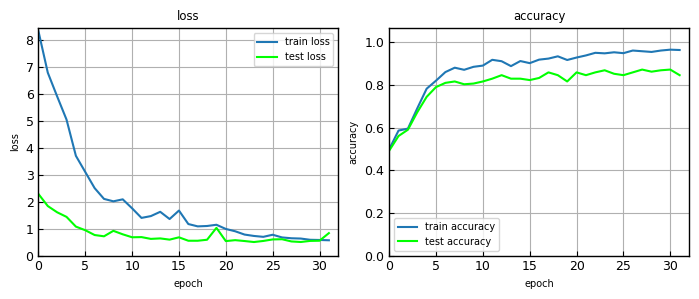

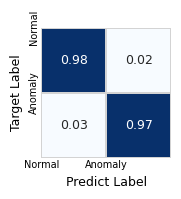

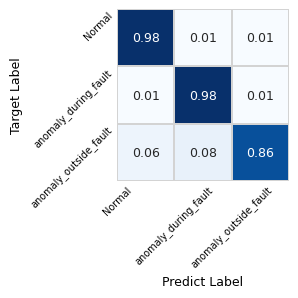

,accuracy,precision,recall,f1
score,0.97377,0.990501,0.973133,0.98174


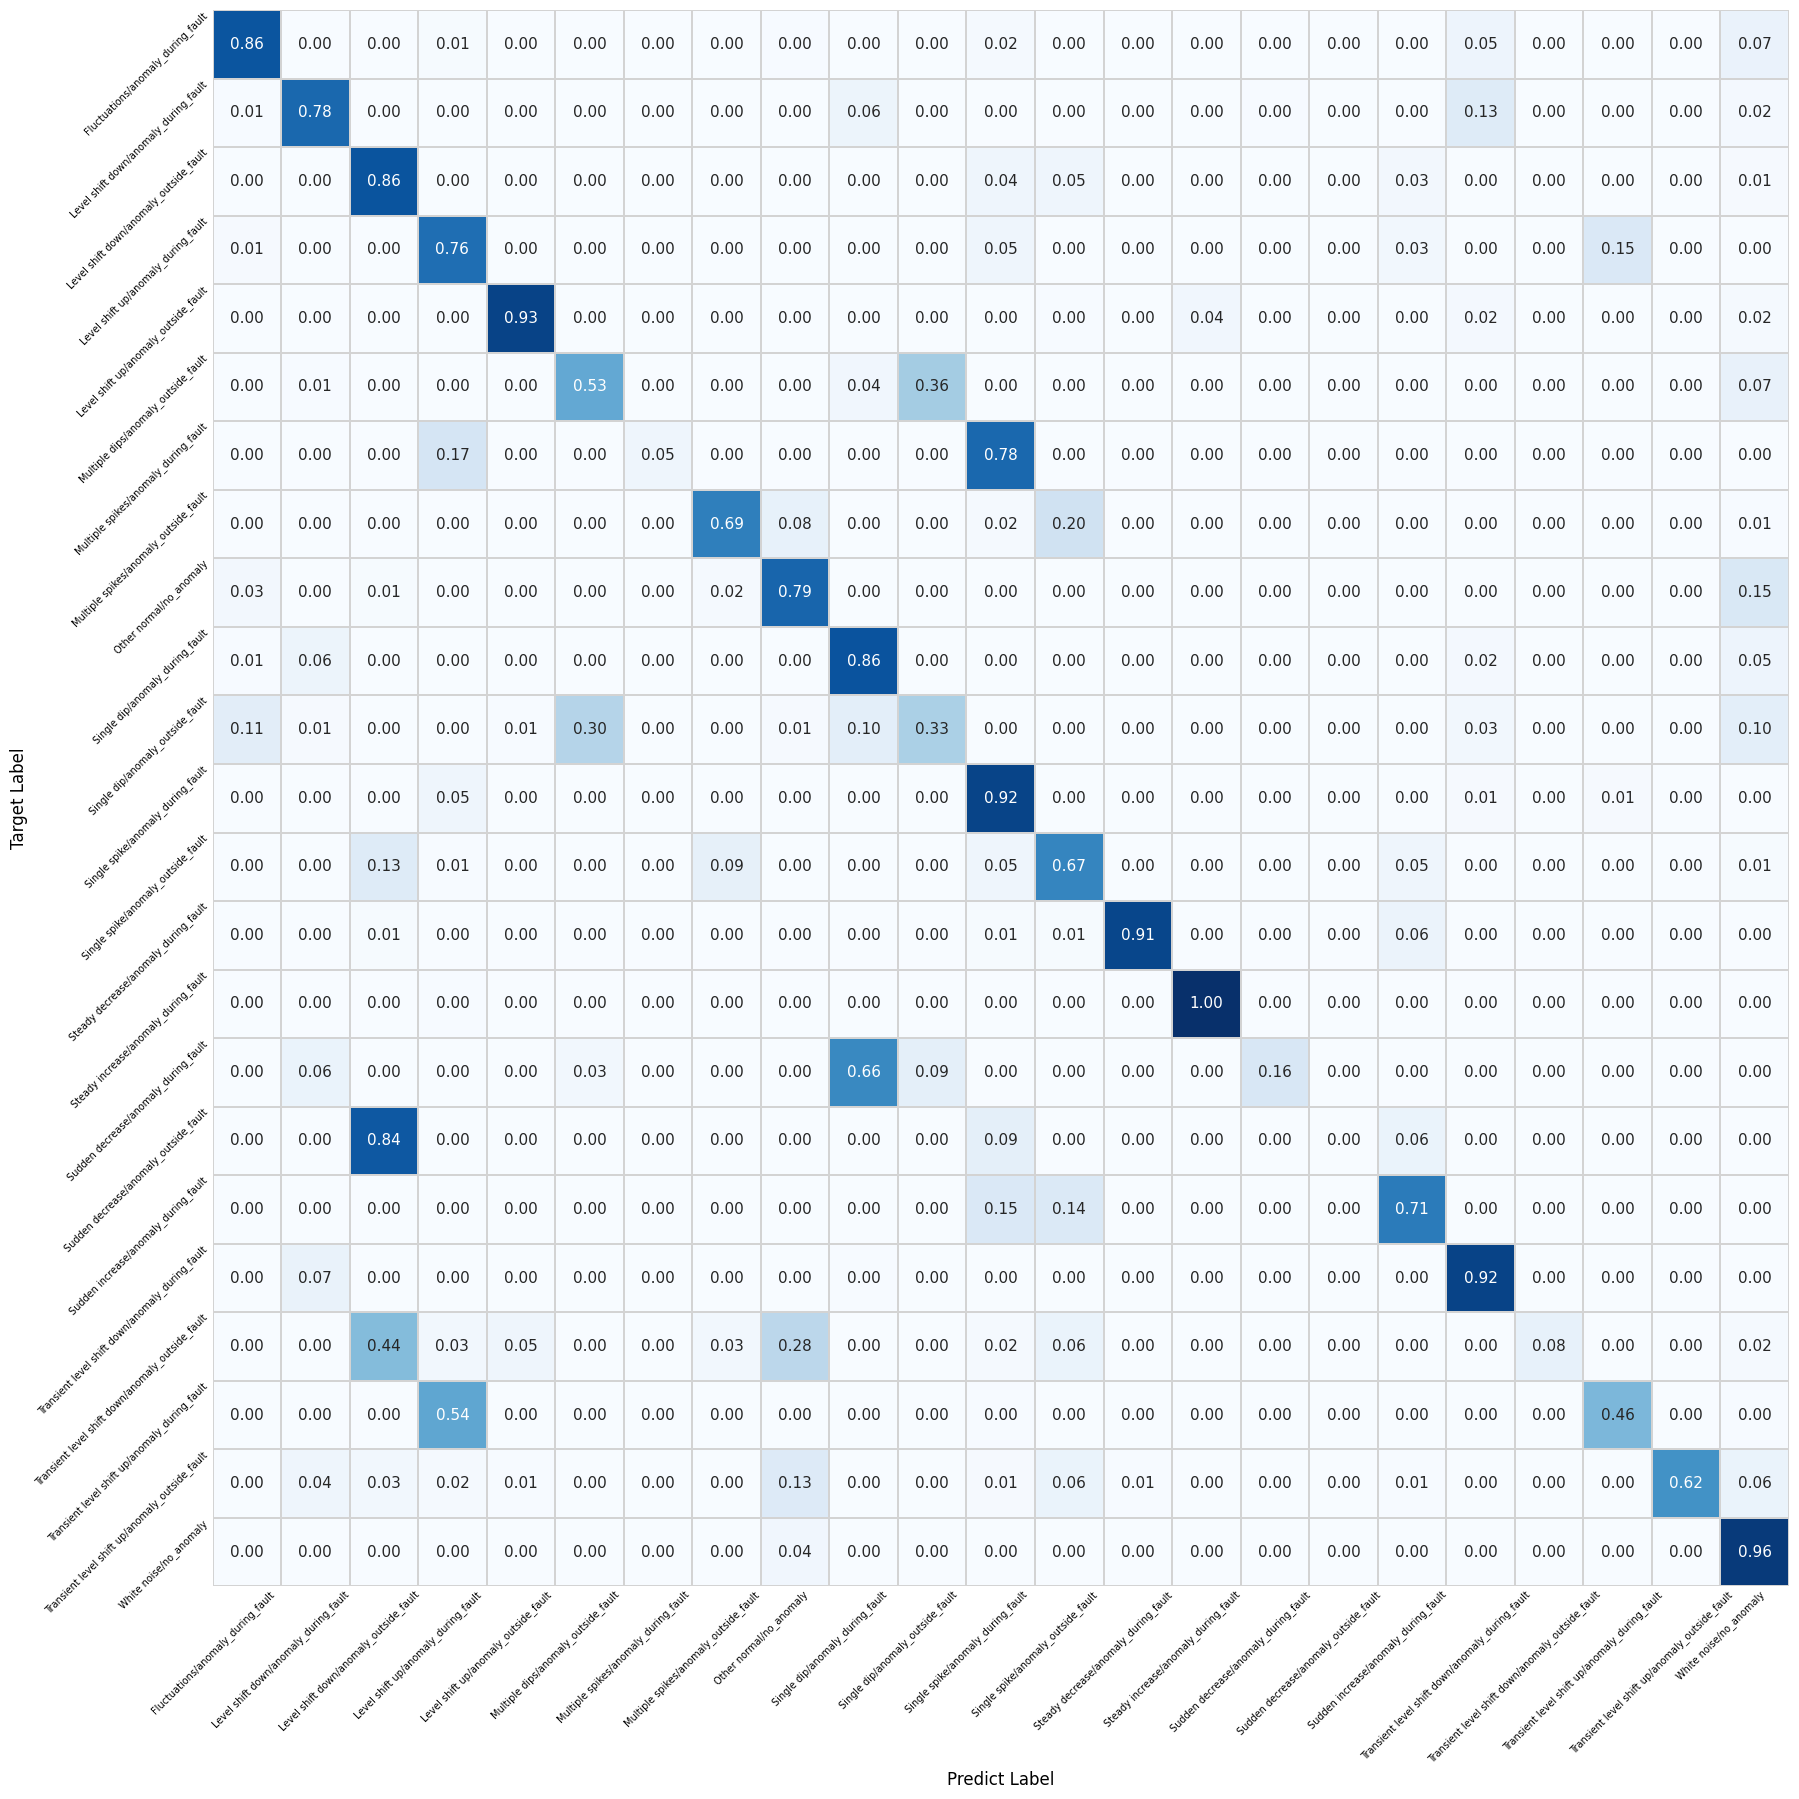

In [131]:
from collections import OrderedDict

from tqdm.notebook import tqdm

from diagnoser.cnn_model import CNN1d


model = CNN1d(num_classes=dataset.number_of_class()).to(device)
learning_rate = 0.001
epochs = 32
batch_size = 16
test_batch_size = 16
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
loss_fn = nn.CrossEntropyLoss()

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=test_batch_size, shuffle=True, pin_memory=True)

score_hist = ScoreHistory(epochs=epochs)
pred_res = PredictionResult(label_to_category=dataset.label_to_category)

with tqdm(range(1, epochs + 1)) as pbar_epochs:
    for epoch in pbar_epochs:
        pbar_epochs.set_description(f"[Epoch {epoch}]")

        train(model, device, train_dataloader, optimizer, loss_fn)
        test_train_data(model, device, train_dataloader, loss_fn, score_hist)
        test(model, device, test_dataloader, loss_fn, score_hist, pred_res)
        train_loss, test_loss = score_hist.latest_loss_pair()
        train_acc, test_acc = score_hist.latest_acc_pair()
        pbar_epochs.set_postfix(OrderedDict(
            train_loss=train_loss, test_loss=test_loss,
            train_acc=train_acc, test_acc=test_acc,
        ))

score_hist.plots()
plt.show()
pred_res.plot_as_anomaly_or_not()
plt.show()
pred_res.plot_as_anomaly_position()
plt.show()
display(pred_res.score_of_bin_class_as_df())
pred_res.plot()
plt.show()

### Save model

In [132]:
torch.save(model, "models/current_best_cnn1d.pt")

In [133]:
current_best_model = torch.load("models/current_best_cnn1d.pt")
summary(current_best_model, input_size=(batch_size, 1, 180))
torch.save(current_best_model.state_dict(), "models/current_best_cnn1d.pth")

## Learning without anomaly positon label

In [109]:
dataset_without_ap = TSDatasetAnomalyPatterns.from_path(
    # pathlib.Path("../samples/tsdr_anomaly_patterns/labeled_tsdr_anomaly_patterns_20221210-145911.jsonl"),
    pathlib.Path("../samples/tsdr_anomaly_patterns/labeled_tsdr_anomaly_patterns_20221202-024759.jsonl"),
    without_anomaly_position=True,
)
print(dataset_without_ap.number_of_class(), len(dataset_without_ap.categories()))
display(dataset_without_ap.df.groupby(["anomaly_pattern"]).size().sort_values(ascending=False))

train_indices, test_indices = train_test_split(list(range(len(dataset_without_ap.labels))), test_size=0.2, stratify=dataset_without_ap.labels.tolist())
train_dataset = torch.utils.data.Subset(dataset_without_ap, train_indices)
test_dataset = torch.utils.data.Subset(dataset_without_ap, test_indices)

print(f"train size {len(train_dataset)}, test size {len(test_dataset)}")

15 15


anomaly_pattern
White noise                   267
Level shift down              155
Single spike                  133
Other normal                  127
Level shift up                100
Transient level shift up       68
Transient level shift down     63
Single dip                     54
Steady decrease                49
Multiple spikes                42
Steady increase                39
Fluctuations                   38
Multiple dips                  27
Sudden increase                26
Sudden decrease                 5
dtype: int64

train size 954, test size 239


  0%|          | 0/32 [00:00<?, ?it/s]

Train set: Average loss: 5.3036, Accuracy: 554/954 (58%)
Test set: Average loss: 1.3908, Accuracy: 129/239 (54%)
Train set: Average loss: 4.8346, Accuracy: 612/954 (64%)
Test set: Average loss: 1.2761, Accuracy: 148/239 (62%)
Train set: Average loss: 3.5674, Accuracy: 678/954 (71%)
Test set: Average loss: 1.0014, Accuracy: 158/239 (66%)
Train set: Average loss: 3.4118, Accuracy: 699/954 (73%)
Test set: Average loss: 0.9734, Accuracy: 158/239 (66%)
Train set: Average loss: 2.6126, Accuracy: 737/954 (77%)
Test set: Average loss: 0.7898, Accuracy: 169/239 (71%)
Train set: Average loss: 2.4725, Accuracy: 798/954 (84%)
Test set: Average loss: 0.7791, Accuracy: 177/239 (74%)
Train set: Average loss: 1.8587, Accuracy: 799/954 (84%)
Test set: Average loss: 0.6848, Accuracy: 172/239 (72%)
Train set: Average loss: 1.6598, Accuracy: 829/954 (87%)
Test set: Average loss: 0.6490, Accuracy: 184/239 (77%)
Train set: Average loss: 1.5557, Accuracy: 839/954 (88%)
Test set: Average loss: 0.6373, Accurac

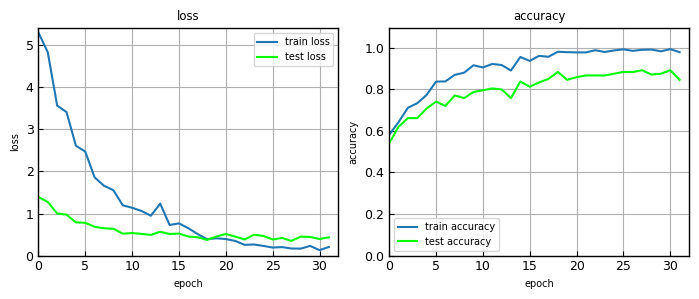

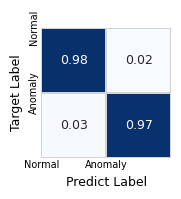

,accuracy,precision,recall,f1
score,0.972803,0.988924,0.970497,0.979624


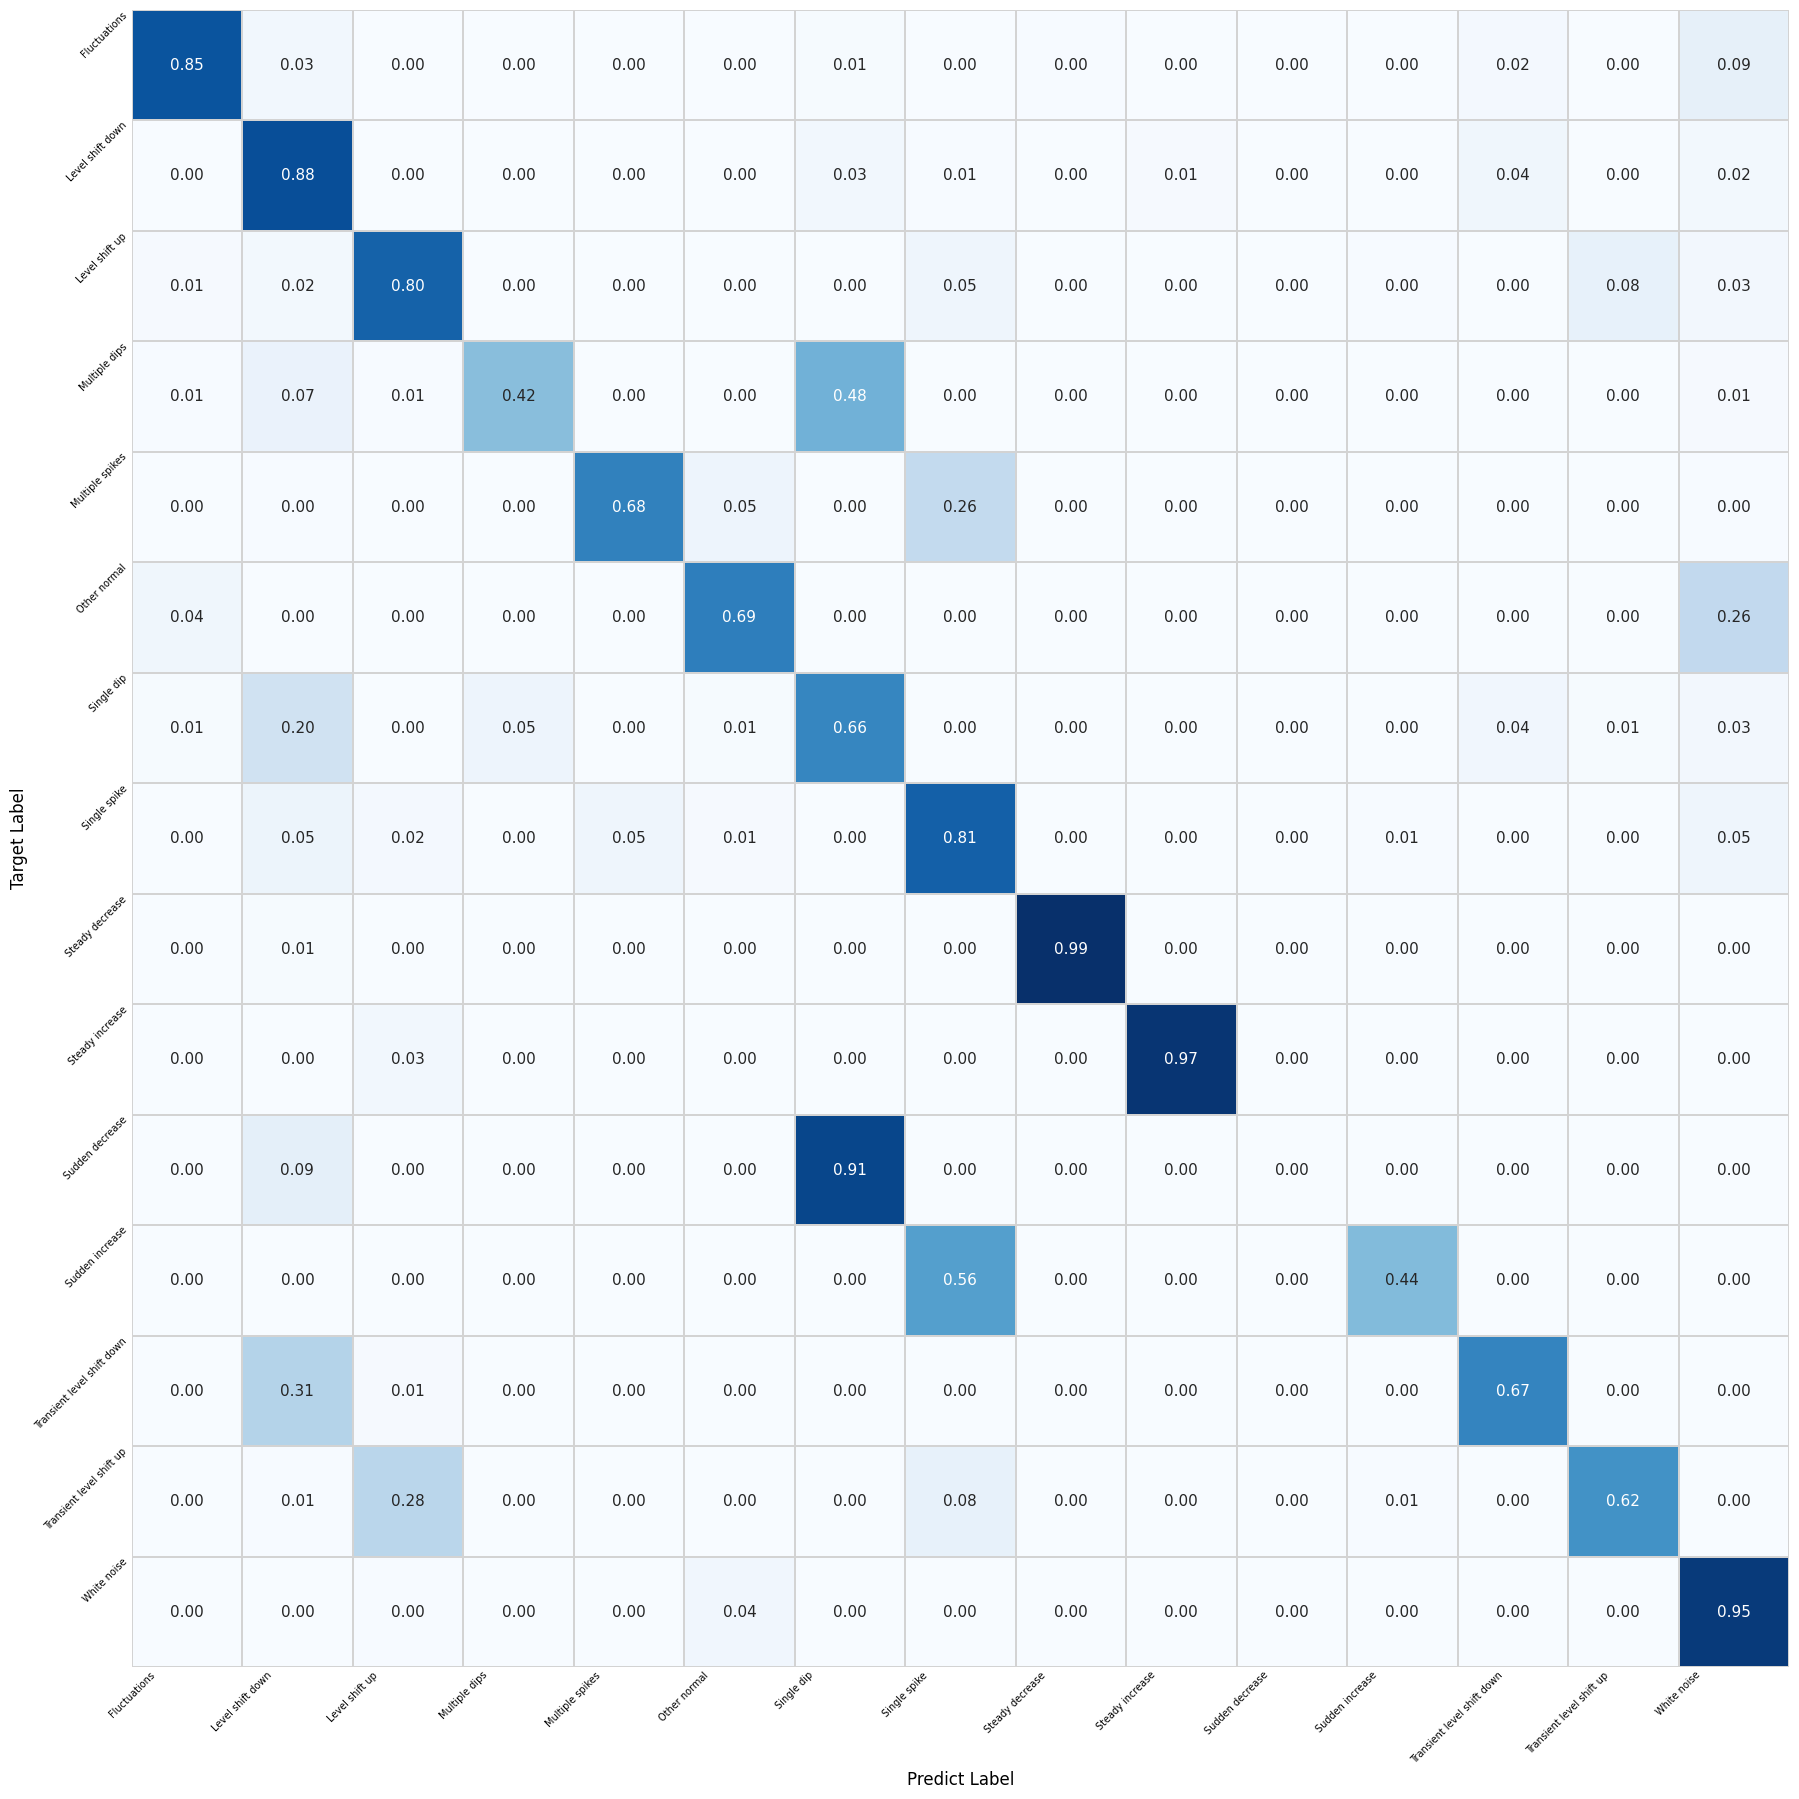

In [110]:
from diagnoser.cnn_model import CNN1d

model_without_ap = CNN1d(num_classes=dataset_without_ap.number_of_class()).to(device)
learning_rate = 0.001
epochs = 32
batch_size = 16
test_batch_size = 16
optimizer = optim.Adam(model_without_ap.parameters(), lr=learning_rate)
loss_fn = nn.CrossEntropyLoss()

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=test_batch_size, shuffle=True, pin_memory=True)

score_hist = ScoreHistory(epochs=epochs)
pred_res = PredictionResult(label_to_category=dataset_without_ap.label_to_category)

with tqdm(range(1, epochs + 1)) as pbar_epochs:
    for epoch in pbar_epochs:
        pbar_epochs.set_description(f"[Epoch {epoch}]")

        train(model_without_ap, device, train_dataloader, optimizer, loss_fn)
        test_train_data(model_without_ap, device, train_dataloader, loss_fn, score_hist)
        test(model_without_ap, device, test_dataloader, loss_fn, score_hist, pred_res)
        train_loss, test_loss = score_hist.latest_loss_pair()
        train_acc, test_acc = score_hist.latest_acc_pair()
        pbar_epochs.set_postfix(OrderedDict(
            train_loss=train_loss, test_loss=test_loss,
            train_acc=train_acc, test_acc=test_acc,
        ))

score_hist.plots()
plt.show()
pred_res.plot_as_anomaly_or_not()
plt.show()
display(pred_res.score_of_bin_class_as_df())
pred_res.plot()
plt.show()

In [111]:
torch.save(model_without_ap.state_dict(), "models/current_best_cnn1d_without_ap.pth")

## Learning samples with data augumentation (DA)

In [112]:
# load
samples_df_with_da = pd.read_parquet(
    "../samples/tsdr_anomaly_patterns_with_da/labeled_tsdr_anomaly_patterns_20221202-024759_with_da.parquet",
)
print(samples_df_with_da.shape)
samples_df_with_da.head()

(7188, 11)


,dataset_id,target_app,chaos_type,chaos_comp,metric,time_series,anomaly_pattern,anomaly_position,DA/noise,DA/va_reverse,DA/ha_reverse
0,qknmc,sock-shop,pod-memory-hog,orders,m-carts_java_lang_GarbageCollector_LastGcInfo_...,"[998.4, 998.4, 998.4, 998.4, 998.4, 998.8667, ...",Fluctuations,anomaly_during_fault,False,False,False
1,qknmc,sock-shop,pod-memory-hog,orders,c-front-end_memory_rss,"[103673856.0, 103809024.0, 103809024.0, 103809...",Fluctuations,anomaly_during_fault,False,False,False
2,qknmc,sock-shop,pod-memory-hog,orders,m-user-db_mongodb_sys_memory_Inactive_anon_kb,"[445804.0, 446900.0, 446116.0, 449476.0, 44577...",Fluctuations,anomaly_during_fault,False,False,False
3,qknmc,sock-shop,pod-memory-hog,orders,m-front-end_process_heap_bytes,"[75784000.0, 74768000.0, 80656000.0, 74776000....",Fluctuations,anomaly_during_fault,False,False,False
4,qknmc,sock-shop,pod-memory-hog,orders,m-orders_java_nio_BufferPool_Count,"[32.0, 32.0, 32.0, 32.0, 32.0, 32.0, 32.0, 32....",Level shift down,anomaly_during_fault,False,False,False


In [113]:
def get_train_test_dataset_with_da(samples_df_with_da: pd.DataFrame, without_anomaly_position: bool = False) -> tuple[TSDatasetAnomalyPatterns, torch.utils.data.Subset, torch.utils.data.Subset]:
    dataset_with_da = TSDatasetAnomalyPatterns(samples_df_with_da, without_anomaly_position=without_anomaly_position)
    print(dataset_with_da.number_of_class(), len(dataset_with_da.categories()))
    display(dataset_with_da.label_to_category)
    if without_anomaly_position:
        display(dataset_with_da.df.groupby(["anomaly_pattern"]).size().sort_values(ascending=False))
    else:
        display(dataset_with_da.df.groupby(["anomaly_pattern", "anomaly_position"]).size().sort_values(ascending=False))

    ## test data should not include only data without DA
    samples_df_with_orig_only = samples_df_with_da[~samples_df_with_da["DA/noise"]][~samples_df_with_da['DA/ha_reverse']][~samples_df_with_da['DA/va_reverse']]
    samples_df_with_da_only = samples_df_with_da[~samples_df_with_da.index.isin(samples_df_with_orig_only.index)]
    print(samples_df_with_da.shape, samples_df_with_orig_only.shape, samples_df_with_da_only.shape)
    assert samples_df_with_orig_only.shape[0] + samples_df_with_da_only.shape[0] == samples_df_with_da.shape[0]

    dataset_with_orig_only = TSDatasetAnomalyPatterns(samples_df_with_orig_only, without_anomaly_position=without_anomaly_position)
    train_indices_with_orig_only, test_indices_with_orig_only = train_test_split(
        list(range(len(dataset_with_orig_only.labels))), test_size=0.2, stratify=dataset_with_orig_only.labels.tolist())

    train_samples_df_with_da_removed_test_orig_and_da = samples_df_with_da.copy()
    test_samples_df_with_orig_only = samples_df_with_orig_only.iloc[test_indices_with_orig_only, :]
    ## remove da data from train data using test_indices_with_orig_only
    for row in test_samples_df_with_orig_only.itertuples():
        remove_idx = train_samples_df_with_da_removed_test_orig_and_da.query(
            "dataset_id == @row.dataset_id and target_app == @row.target_app and chaos_type == @row.chaos_type and chaos_comp == @row.chaos_comp and metric == @row.metric"
        ).index
        train_samples_df_with_da_removed_test_orig_and_da.drop(remove_idx, inplace=True)
    print(train_samples_df_with_da_removed_test_orig_and_da.shape)

    train_dataset = TSDatasetAnomalyPatterns(
        train_samples_df_with_da_removed_test_orig_and_da.reset_index(drop=True),
        without_anomaly_position=without_anomaly_position,
    )
    test_dataset = torch.utils.data.Subset(dataset_with_orig_only, test_indices_with_orig_only)

    print(f"train size {len(train_dataset)}, test size {len(test_dataset)}")
    return dataset_with_da, train_dataset, test_dataset 

15 15


OrderedDict([(0, 'Fluctuations'),
             (1, 'Level shift down'),
             (2, 'Level shift up'),
             (3, 'Multiple dips'),
             (4, 'Multiple spikes'),
             (5, 'Other normal'),
             (6, 'Single dip'),
             (7, 'Single spike'),
             (8, 'Steady decrease'),
             (9, 'Steady increase'),
             (10, 'Sudden decrease'),
             (11, 'Sudden increase'),
             (12, 'Transient level shift down'),
             (13, 'Transient level shift up'),
             (14, 'White noise')])

anomaly_pattern
White noise                   1602
Level shift up                 840
Level shift down               778
Other normal                   762
Single spike                   640
Single dip                     482
Transient level shift up       398
Transient level shift down     388
Steady increase                274
Steady decrease                254
Fluctuations                   228
Multiple spikes                222
Multiple dips                  192
Sudden decrease                 64
Sudden increase                 64
dtype: int64

(7188, 11) (1198, 11) (5990, 11)
(5742, 11)
train size 5742, test size 240


  0%|          | 0/32 [00:00<?, ?it/s]

Train set: Average loss: 0.5318, Accuracy: 3738/5742 (65%)
Test set: Average loss: 1.3770, Accuracy: 157/240 (65%)
Train set: Average loss: 0.3347, Accuracy: 4110/5742 (72%)
Test set: Average loss: 0.8392, Accuracy: 175/240 (73%)
Train set: Average loss: 0.2203, Accuracy: 4729/5742 (82%)
Test set: Average loss: 0.6041, Accuracy: 191/240 (80%)
Train set: Average loss: 0.2000, Accuracy: 4762/5742 (83%)
Test set: Average loss: 0.6148, Accuracy: 189/240 (79%)
Train set: Average loss: 0.1464, Accuracy: 5051/5742 (88%)
Test set: Average loss: 0.4829, Accuracy: 194/240 (81%)
Train set: Average loss: 0.1323, Accuracy: 5058/5742 (88%)
Test set: Average loss: 0.4548, Accuracy: 203/240 (85%)
Train set: Average loss: 0.1047, Accuracy: 5225/5742 (91%)
Test set: Average loss: 0.4284, Accuracy: 204/240 (85%)
Train set: Average loss: 0.0912, Accuracy: 5304/5742 (92%)
Test set: Average loss: 0.4068, Accuracy: 204/240 (85%)
Train set: Average loss: 0.0791, Accuracy: 5359/5742 (93%)
Test set: Average los

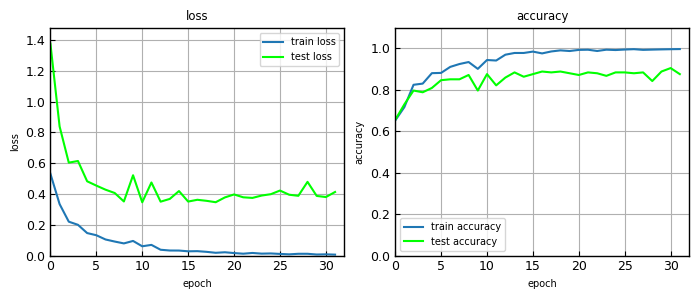

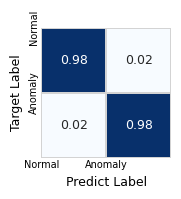

,accuracy,precision,recall,f1
score,0.983464,0.992022,0.98341,0.987697


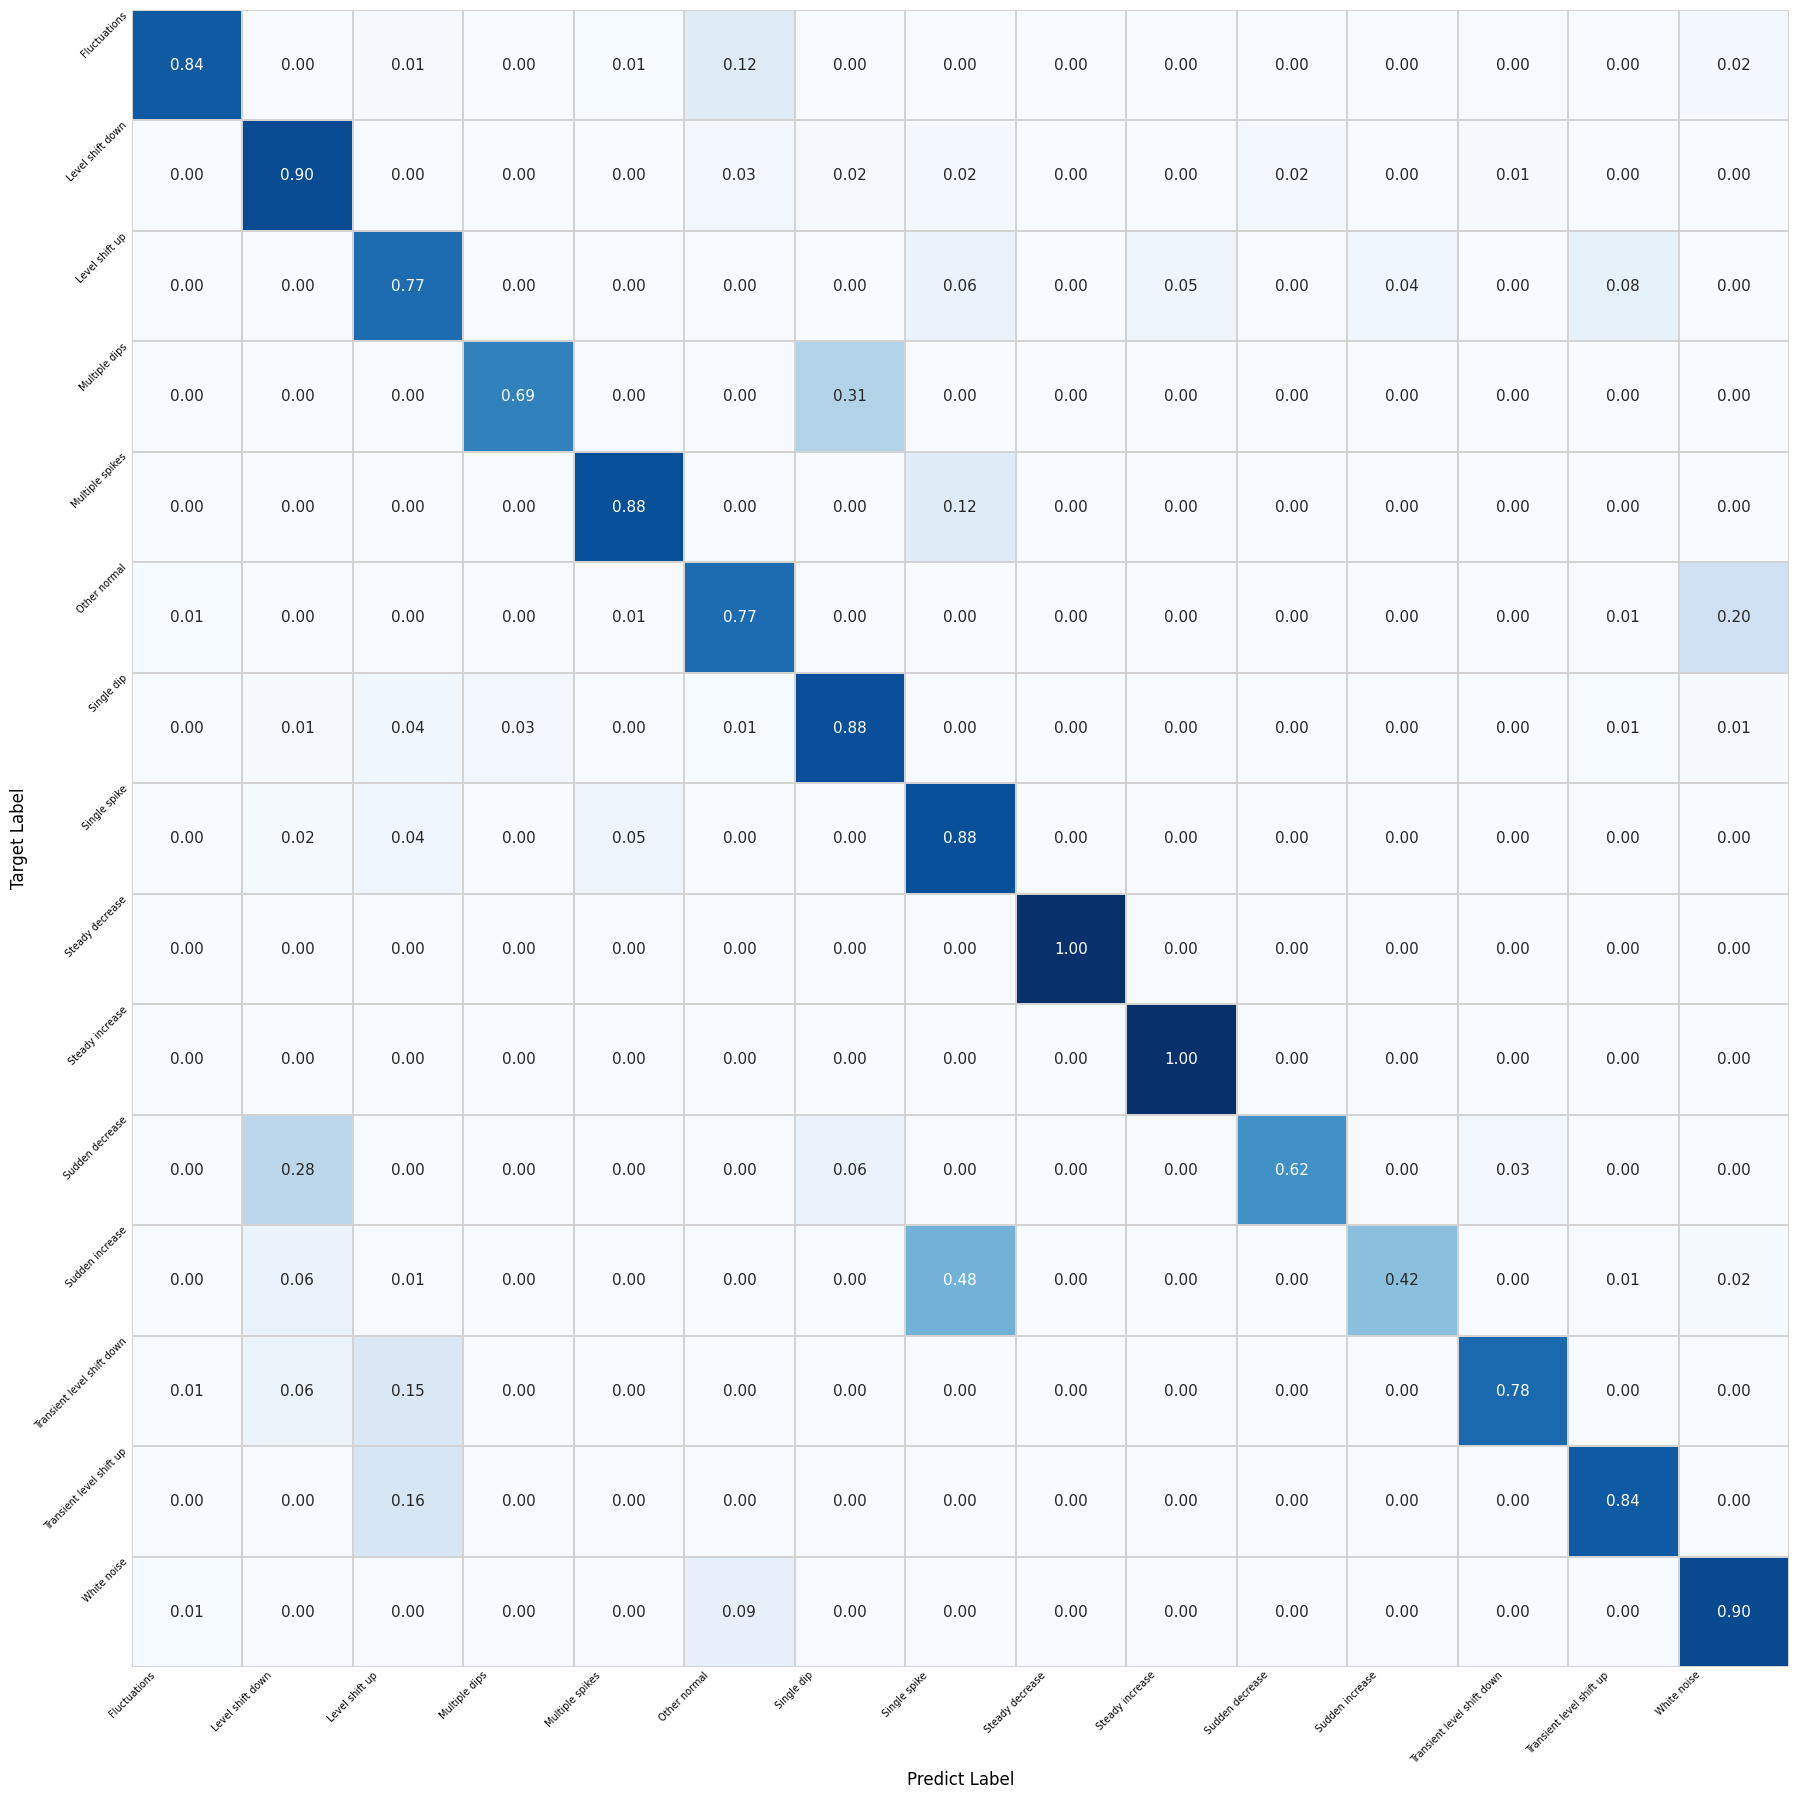

In [114]:
from diagnoser.cnn_model import CNN1d

dataset_with_da_without_ap, train_dataset, test_dataset = get_train_test_dataset_with_da(samples_df_with_da, without_anomaly_position=True)
model_with_da_without_ap = CNN1d(num_classes=dataset_with_da_without_ap.number_of_class()).to(device)
learning_rate = 0.001
epochs = 32
batch_size = 128
test_batch_size = 16
optimizer = optim.Adam(model_with_da_without_ap.parameters(), lr=learning_rate)
loss_fn = nn.CrossEntropyLoss()

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=test_batch_size, shuffle=True, pin_memory=True)

score_hist = ScoreHistory(epochs=epochs)
pred_res = PredictionResult(label_to_category=dataset_with_da_without_ap.label_to_category)

with tqdm(range(1, epochs + 1)) as pbar_epochs:
    for epoch in pbar_epochs:
        pbar_epochs.set_description(f"[Epoch {epoch}]")

        train(model_with_da_without_ap, device, train_dataloader, optimizer, loss_fn)
        test_train_data(model_with_da_without_ap, device, train_dataloader, loss_fn, score_hist)
        test(model_with_da_without_ap, device, test_dataloader, loss_fn, score_hist, pred_res)
        train_loss, test_loss = score_hist.latest_loss_pair()
        train_acc, test_acc = score_hist.latest_acc_pair()
        pbar_epochs.set_postfix(OrderedDict(
            train_loss=train_loss, test_loss=test_loss,
            train_acc=train_acc, test_acc=test_acc,
        ))

score_hist.plots()
plt.show()
pred_res.plot_as_anomaly_or_not()
plt.show()
display(pred_res.score_of_bin_class_as_df())
pred_res.plot()
plt.show()

In [119]:
torch.save(model_with_da_without_ap.state_dict(), "models/current_best_cnn1d_without_ap_with_da.pth")

### With anomaly position label

In [120]:
# load
samples_df_with_da_with_ap = pd.read_parquet(
    "../samples/tsdr_anomaly_patterns_with_da/labeled_tsdr_anomaly_patterns_20221202-024759_with_da_with_anomaly_position.parquet",
)
print(samples_df_with_da_with_ap.shape)
samples_df_with_da_with_ap.head()

(5840, 11)


,dataset_id,target_app,chaos_type,chaos_comp,metric,time_series,anomaly_pattern,anomaly_position,DA/noise,DA/va_reverse,DA/ha_reverse
0,qknmc,sock-shop,pod-memory-hog,orders,m-carts_java_lang_GarbageCollector_LastGcInfo_...,"[998.4, 998.4, 998.4, 998.4, 998.4, 998.8667, ...",Fluctuations,anomaly_during_fault,False,False,False
1,qknmc,sock-shop,pod-memory-hog,orders,c-front-end_memory_rss,"[103673856.0, 103809024.0, 103809024.0, 103809...",Fluctuations,anomaly_during_fault,False,False,False
2,qknmc,sock-shop,pod-memory-hog,orders,m-user-db_mongodb_sys_memory_Inactive_anon_kb,"[445804.0, 446900.0, 446116.0, 449476.0, 44577...",Fluctuations,anomaly_during_fault,False,False,False
3,qknmc,sock-shop,pod-memory-hog,orders,m-front-end_process_heap_bytes,"[75784000.0, 74768000.0, 80656000.0, 74776000....",Fluctuations,anomaly_during_fault,False,False,False
4,qknmc,sock-shop,pod-memory-hog,orders,m-orders_java_nio_BufferPool_Count,"[32.0, 32.0, 32.0, 32.0, 32.0, 32.0, 32.0, 32....",Level shift down,anomaly_during_fault,False,False,False


28 28


OrderedDict([(0, 'Fluctuations/anomaly_during_fault'),
             (1, 'Fluctuations/anomaly_outside_fault'),
             (2, 'Level shift down/anomaly_during_fault'),
             (3, 'Level shift down/anomaly_outside_fault'),
             (4, 'Level shift up/anomaly_during_fault'),
             (5, 'Level shift up/anomaly_outside_fault'),
             (6, 'Multiple dips/anomaly_during_fault'),
             (7, 'Multiple dips/anomaly_outside_fault'),
             (8, 'Multiple spikes/anomaly_during_fault'),
             (9, 'Multiple spikes/anomaly_outside_fault'),
             (10, 'Other normal/no_anomaly'),
             (11, 'Single dip/anomaly_during_fault'),
             (12, 'Single dip/anomaly_outside_fault'),
             (13, 'Single spike/anomaly_during_fault'),
             (14, 'Single spike/anomaly_outside_fault'),
             (15, 'Steady decrease/anomaly_during_fault'),
             (16, 'Steady decrease/anomaly_outside_fault'),
             (17, 'Steady increase/ano

anomaly_pattern             anomaly_position     
White noise                 no_anomaly               1068
Other normal                no_anomaly                508
Level shift down            anomaly_outside_fault     400
                            anomaly_during_fault      396
Single spike                anomaly_outside_fault     390
Level shift up              anomaly_outside_fault     378
Single spike                anomaly_during_fault      284
Level shift up              anomaly_during_fault      248
Transient level shift down  anomaly_during_fault      212
Steady decrease             anomaly_during_fault      196
Transient level shift up    anomaly_outside_fault     192
                            anomaly_during_fault      160
Multiple spikes             anomaly_outside_fault     160
Steady increase             anomaly_during_fault      156
Fluctuations                anomaly_during_fault      152
Single dip                  anomaly_during_fault      148
Transient level shift 

(5840, 11) (1198, 11) (4642, 11)
(4654, 11)
train size 4654, test size 240
number of class: 28 number of categories 28 ['Fluctuations/anomaly_during_fault', 'Fluctuations/anomaly_outside_fault', 'Level shift down/anomaly_during_fault', 'Level shift down/anomaly_outside_fault', 'Level shift up/anomaly_during_fault', 'Level shift up/anomaly_outside_fault', 'Multiple dips/anomaly_during_fault', 'Multiple dips/anomaly_outside_fault', 'Multiple spikes/anomaly_during_fault', 'Multiple spikes/anomaly_outside_fault', 'Other normal/no_anomaly', 'Single dip/anomaly_during_fault', 'Single dip/anomaly_outside_fault', 'Single spike/anomaly_during_fault', 'Single spike/anomaly_outside_fault', 'Steady decrease/anomaly_during_fault', 'Steady decrease/anomaly_outside_fault', 'Steady increase/anomaly_during_fault', 'Steady increase/anomaly_outside_fault', 'Sudden decrease/anomaly_during_fault', 'Sudden decrease/anomaly_outside_fault', 'Sudden increase/anomaly_during_fault', 'Sudden increase/anomaly_outs

  0%|          | 0/32 [00:00<?, ?it/s]

Train set: Average loss: 0.5466, Accuracy: 2476/4654 (53%)
Test set: Average loss: 1.6217, Accuracy: 140/240 (58%)
Train set: Average loss: 0.4401, Accuracy: 3348/4654 (72%)
Test set: Average loss: 1.4699, Accuracy: 160/240 (67%)
Train set: Average loss: 0.2732, Accuracy: 3601/4654 (77%)
Test set: Average loss: 0.9224, Accuracy: 177/240 (74%)
Train set: Average loss: 0.2291, Accuracy: 3719/4654 (80%)
Test set: Average loss: 0.8926, Accuracy: 166/240 (69%)
Train set: Average loss: 0.1318, Accuracy: 4129/4654 (89%)
Test set: Average loss: 0.5653, Accuracy: 204/240 (85%)
Train set: Average loss: 0.1158, Accuracy: 4202/4654 (90%)
Test set: Average loss: 0.6146, Accuracy: 197/240 (82%)
Train set: Average loss: 0.0857, Accuracy: 4289/4654 (92%)
Test set: Average loss: 0.5548, Accuracy: 201/240 (84%)
Train set: Average loss: 0.0643, Accuracy: 4403/4654 (95%)
Test set: Average loss: 0.5017, Accuracy: 205/240 (85%)
Train set: Average loss: 0.0654, Accuracy: 4376/4654 (94%)
Test set: Average los

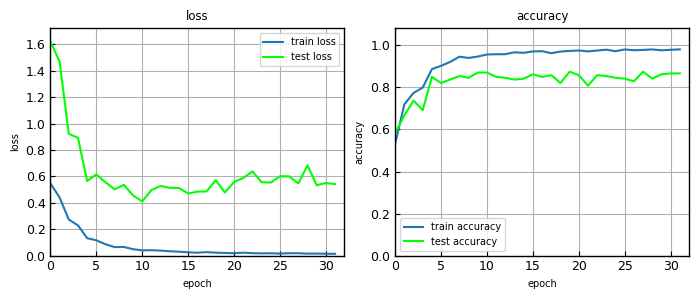

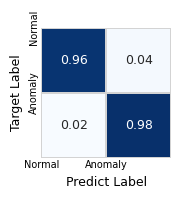

,accuracy,precision,recall,f1
score,0.972917,0.980626,0.978711,0.979668


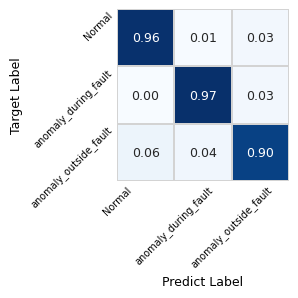

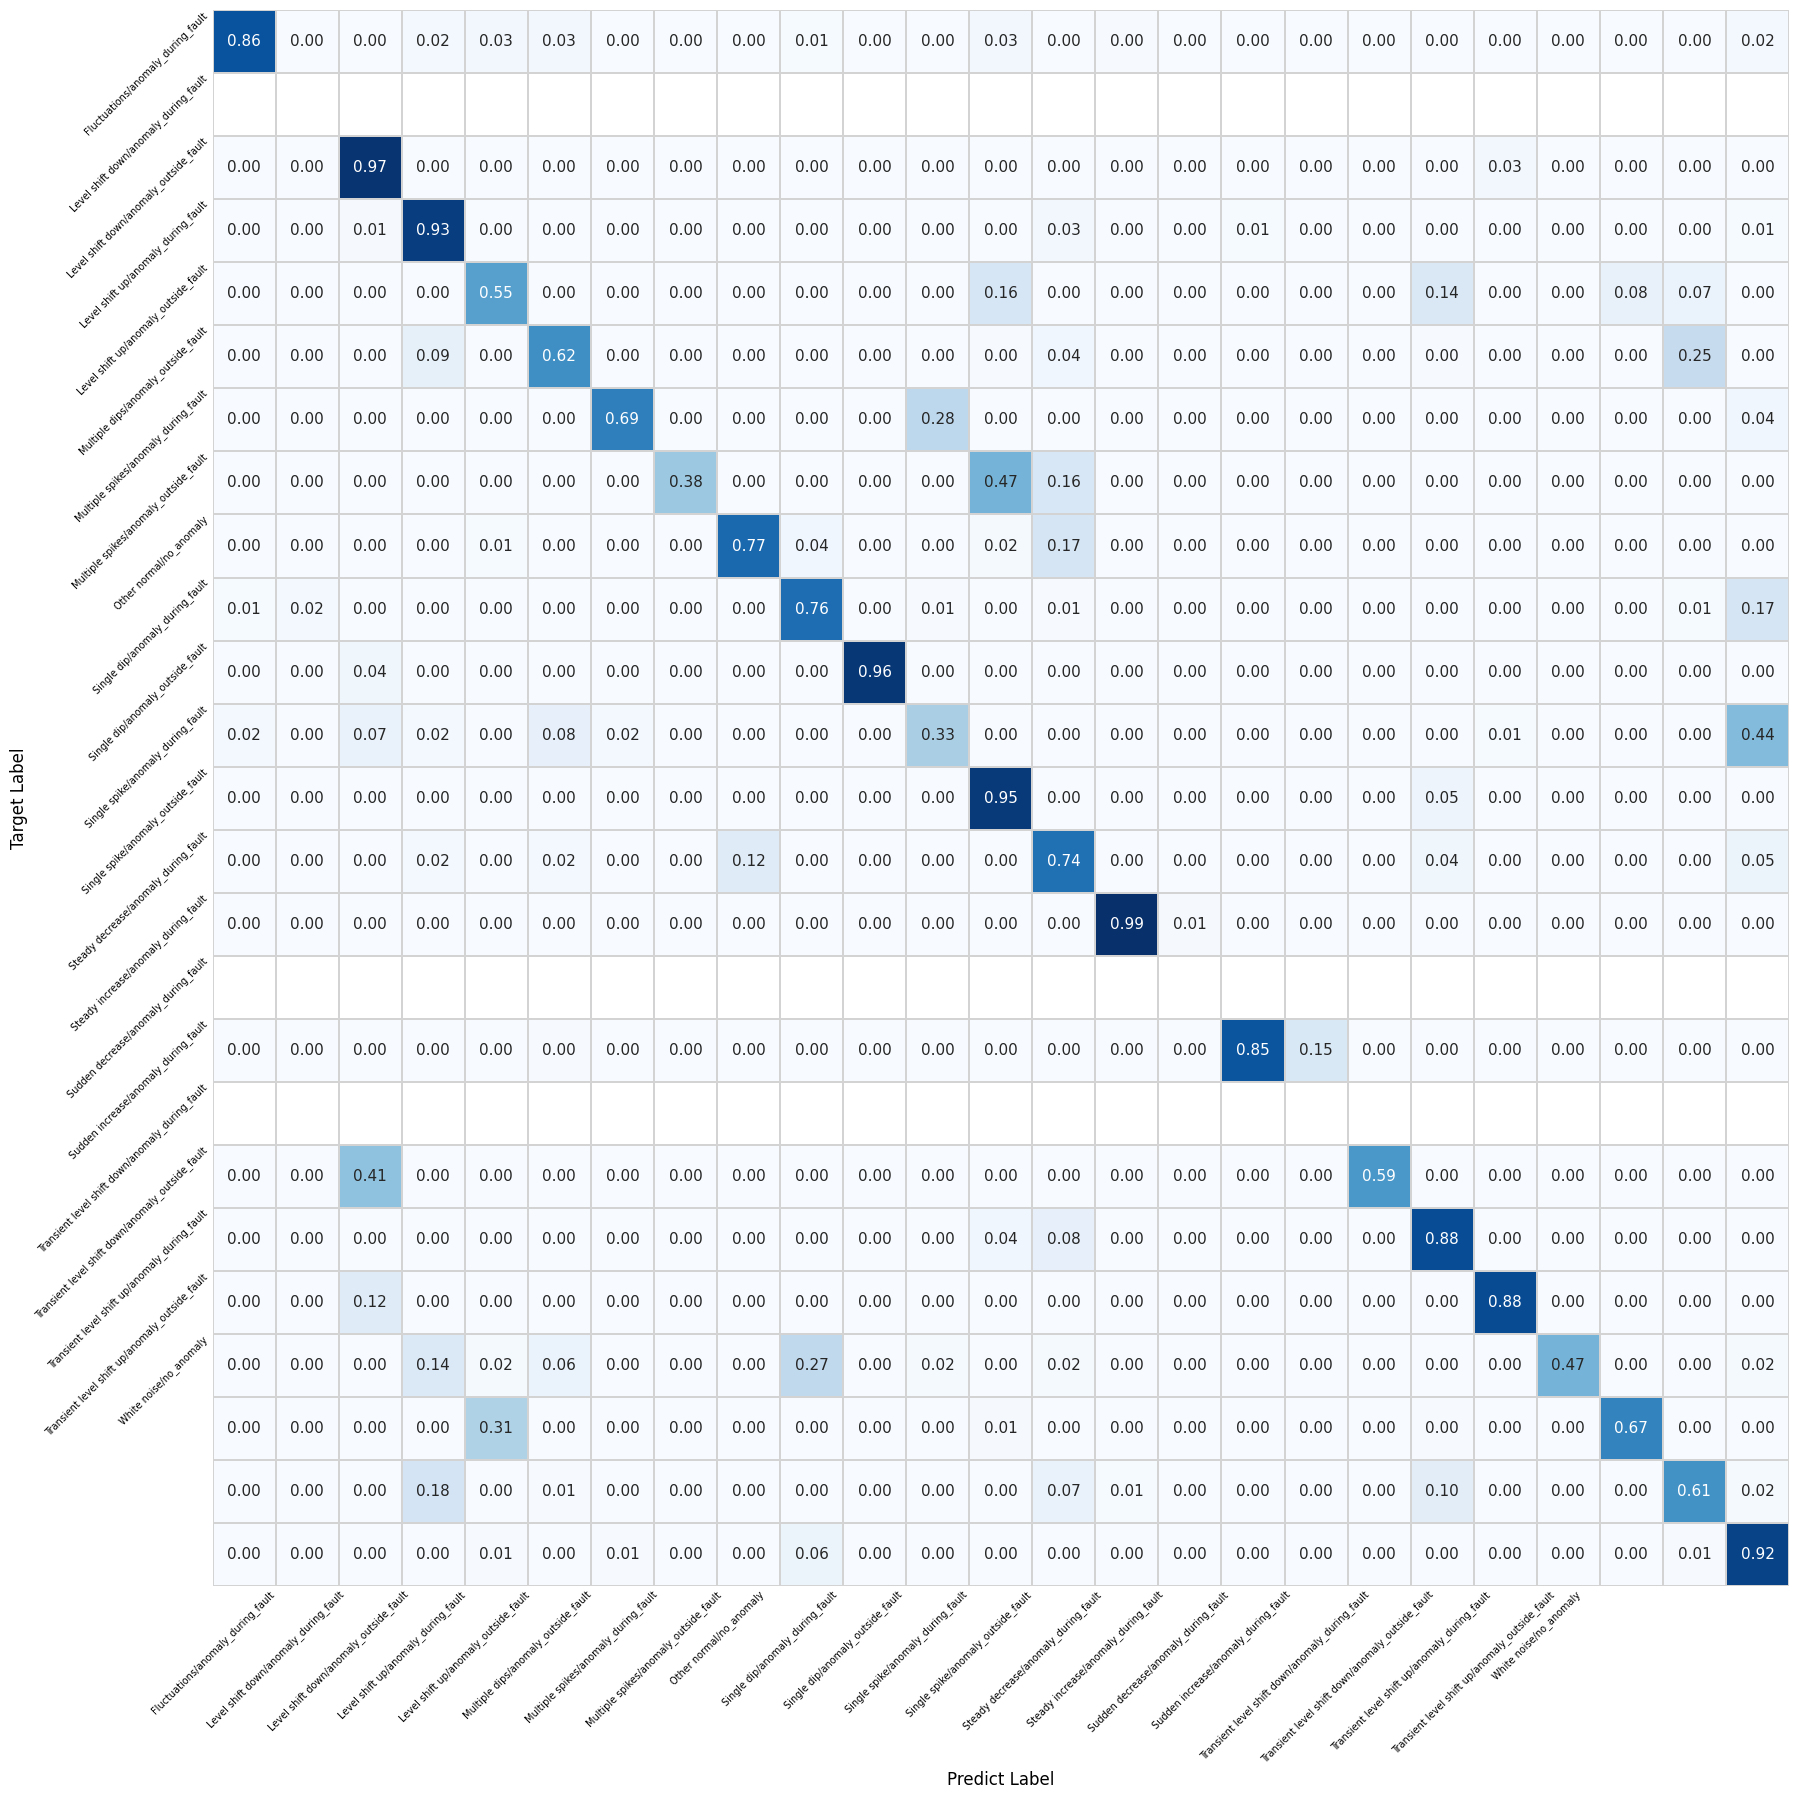

In [134]:
from diagnoser.cnn_model import CNN1d

dataset_with_da, train_dataset, test_dataset = get_train_test_dataset_with_da(samples_df_with_da_with_ap, without_anomaly_position=False)
model_with_da = CNN1d(num_classes=dataset_with_da.number_of_class()).to(device)
learning_rate = 0.001
epochs = 32
batch_size = 128
test_batch_size = 16
optimizer = optim.Adam(model_with_da.parameters(), lr=learning_rate)
loss_fn = nn.CrossEntropyLoss()

print(f"number of class: {dataset_with_da.number_of_class()}", f"number of categories {len(dataset_with_da.categories())} {dataset_with_da.categories()}")

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=test_batch_size, shuffle=True, pin_memory=True)

score_hist = ScoreHistory(epochs=epochs)
pred_res = PredictionResult(label_to_category=dataset_with_da.label_to_category)

with tqdm(range(1, epochs + 1)) as pbar_epochs:
    for epoch in pbar_epochs:
        pbar_epochs.set_description(f"[Epoch {epoch}]")

        train(model_with_da, device, train_dataloader, optimizer, loss_fn)
        test_train_data(model_with_da, device, train_dataloader, loss_fn, score_hist)
        test(model_with_da, device, test_dataloader, loss_fn, score_hist, pred_res)
        train_loss, test_loss = score_hist.latest_loss_pair()
        train_acc, test_acc = score_hist.latest_acc_pair()
        pbar_epochs.set_postfix(OrderedDict(
            train_loss=train_loss, test_loss=test_loss,
            train_acc=train_acc, test_acc=test_acc,
        ))

score_hist.plots()
plt.show()
pred_res.plot_as_anomaly_or_not()
plt.show()
display(pred_res.score_of_bin_class_as_df())
pred_res.plot_as_anomaly_position()
plt.show()
pred_res.plot()
plt.show()

In [135]:
torch.save(model_with_da.state_dict(), "models/current_best_cnn1d_with_da.pth")